# 1. Import and Install Dependencies

## 1.1 Install Our Dependencies

In [ ]:
!pip install tensorflow tensorflow-io matplotlib

## 1.2 Load Dependencies

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

## 1.3 Lets Get Our Data In!

In [3]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

!kaggle datasets download -d mfekadu/english-multispeaker-corpus-for-voice-cloning/

!unzip -qq english-multispeaker-corpus-for-voice-cloning.zip

100% 10.4G/10.4G [01:54<00:00, 80.8MB/s]
100% 10.4G/10.4G [01:54<00:00, 97.0MB/s]


## 1.35 Find Common Files!

In [4]:
import shutil
import fnmatch
import re

# Pre-calculate common_files
original_data_dir = '/content/VCTK-Corpus/VCTK-Corpus/wav48'
speaker_files = {}
for speaker_dir in sorted(os.listdir(original_data_dir)):
    speaker_path = os.path.join(original_data_dir, speaker_dir)
    if os.path.isdir(speaker_path):
        speaker_id = speaker_dir[1:] if speaker_dir.startswith('p') else speaker_dir
        wav_files = sorted([f for f in os.listdir(speaker_path) if fnmatch.fnmatch(f, '*.wav')])
        speaker_files[speaker_id] = wav_files

common_files = set()
for speaker_id, files in speaker_files.items():
    for file_name in files:
        match = re.search(r'_(\d+)\.wav$', file_name)
        if match:
            integer_part = match.group(1)
            is_common = all(any(re.search(rf'_{integer_part}\.wav$', f) for f in speaker_files[other_speaker_id])
                           for other_speaker_id in speaker_files if other_speaker_id != speaker_id)
            if is_common:
                common_files.add(file_name)

print(sorted(common_files))

['p225_014.wav', 'p225_016.wav', 'p225_025.wav', 'p225_026.wav', 'p225_027.wav', 'p225_030.wav', 'p225_033.wav', 'p225_046.wav', 'p225_051.wav', 'p225_057.wav', 'p225_066.wav', 'p225_071.wav', 'p225_072.wav', 'p225_109.wav', 'p225_121.wav', 'p225_126.wav', 'p225_128.wav', 'p225_141.wav', 'p225_149.wav', 'p225_176.wav', 'p225_179.wav', 'p226_014.wav', 'p226_016.wav', 'p226_025.wav', 'p226_026.wav', 'p226_027.wav', 'p226_030.wav', 'p226_033.wav', 'p226_046.wav', 'p226_051.wav', 'p226_057.wav', 'p226_066.wav', 'p226_071.wav', 'p226_072.wav', 'p226_109.wav', 'p226_121.wav', 'p226_126.wav', 'p226_128.wav', 'p226_141.wav', 'p226_149.wav', 'p226_176.wav', 'p226_179.wav', 'p227_014.wav', 'p227_016.wav', 'p227_025.wav', 'p227_026.wav', 'p227_027.wav', 'p227_030.wav', 'p227_033.wav', 'p227_046.wav', 'p227_051.wav', 'p227_057.wav', 'p227_066.wav', 'p227_071.wav', 'p227_072.wav', 'p227_109.wav', 'p227_121.wav', 'p227_126.wav', 'p227_128.wav', 'p227_141.wav', 'p227_149.wav', 'p227_176.wav', 'p227_1

## 1.4 Reorganize The Data

In [5]:
# Modified reorganize_data function
def reorganize_data(original_data_dir, new_data_dir, common_files, max_files_per_speaker=60):
    """
    Reorganize the data into speaker folders with a maximum file limit,
    using the pre-calculated common_files.

    :param original_data_dir: Path to the original data directory.
    :param new_data_dir: Path to the new data directory.
    :param common_files: Pre-calculated common files.
    :param max_files_per_speaker: Maximum number of files per speaker.

    :return: None
    """
    for speaker_dir in sorted(os.listdir(original_data_dir)):
        speaker_path = os.path.join(original_data_dir, speaker_dir)
        speaker_id = speaker_dir[1:] if speaker_dir.startswith('p') else speaker_dir # basically just 225 instead of p225

        if os.path.isdir(speaker_path):
            new_speaker_dir = os.path.join(new_data_dir, f'Speaker{speaker_id}')
            os.makedirs(new_speaker_dir, exist_ok=True)

            wav_files = sorted([f for f in os.listdir(speaker_path) if fnmatch.fnmatch(f, '*.wav')])
            file_count = 0
            for file_name in wav_files:
                if file_name in common_files and file_count < max_files_per_speaker:
                    original_file_path = os.path.join(speaker_path, file_name)
                    new_file_path = os.path.join(new_speaker_dir, file_name)
                    shutil.copy(original_file_path, new_file_path)
                    file_count += 1

# Example usage:
original_data_dir = '/content/VCTK-Corpus/VCTK-Corpus/wav48'
new_data_dir = '/data'
reorganize_data(original_data_dir, new_data_dir, common_files)

# 2. Data Loading Function!

## 2.1 Define Paths to Files

In [10]:
P225_WAV_FILE = os.path.join('/data', 'Speaker225','p225_014.wav')
P226_WAV_FILE = os.path.join('/data', 'Speaker226','p226_014.wav')

In [11]:
print(P225_WAV_FILE)
print(P226_WAV_FILE)

/data/Speaker225/p225_014.wav
/data/Speaker226/p226_014.wav


## 2.2 Create Data Loading Function

In [12]:
def load_wav_16k_mono(filename):
  # Load encoded wav file
  file_contents = tf.io.read_file(filename)

  # decode wave file. Instead of getting stereo we will get mono. (easier processing)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)

  # remove trailing axis
  wav = tf.squeeze(wav, axis=-1) # convert to 1D tensor
  sample_rate = tf.cast(sample_rate, dtype=tf.int64) # convert to int64 data type

  # ensure sample rate is 16000Hz - amp of audio signal
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

## 2.25 SOME SANITY CHECKS

In [13]:
# USING SPEAKER p225

file_contents = tf.io.read_file(P225_WAV_FILE)
print(f'file_contents: {file_contents}\n')

wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
print(f'wav: {wav}')
print(f'sample_rate: {sample_rate}\n')

wav = tf.squeeze(wav, axis=-1)
print(f'wav: {wav}')

sample_rate = tf.cast(sample_rate, dtype=tf.int64)
print(f'sample_rate: {sample_rate}\n')

wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
print(f'wav: {wav}\n')

file_contents: b'RIFF\xc0\xc0\t\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80\xbb\x00\x00\x00w\x01\x00\x02\x00\x10\x00data\x9c\xc0\t\x00\\\x00\x95\x00\x80\x00\x84\x00\x87\x00\x82\x00\x83\x00\x89\x00}\x00\x85\x00\x83\x00\x85\x00\x82\x00\x88\x00z\x00\x81\x00\x83\x00\x89\x00|\x00\x86\x00}\x00\x8b\x00\x7f\x00~\x00\x83\x00\x82\x00~\x00\x7f\x00}\x00\x7f\x00~\x00x\x00|\x00y\x00z\x00{\x00{\x00x\x00x\x00z\x00w\x00z\x00w\x00y\x00x\x00u\x00w\x00v\x00u\x00t\x00s\x00w\x00q\x00q\x00v\x00m\x00x\x00o\x00p\x00p\x00s\x00q\x00r\x00o\x00q\x00s\x00r\x00i\x00n\x00l\x00n\x00j\x00h\x00s\x00e\x00n\x00l\x00s\x00m\x00o\x00q\x00v\x00l\x00w\x00s\x00s\x00t\x00o\x00s\x00n\x00n\x00n\x00u\x00h\x00l\x00g\x00n\x00m\x00h\x00h\x00m\x00l\x00n\x00k\x00l\x00p\x00i\x00o\x00j\x00l\x00k\x00k\x00h\x00k\x00l\x00a\x00c\x00i\x00^\x00j\x00_\x00`\x00c\x00b\x00_\x00b\x00j\x00a\x00i\x00a\x00e\x00a\x00j\x00^\x00i\x00]\x00f\x00b\x00d\x00d\x00_\x00d\x00^\x00g\x00`\x00b\x00]\x00g\x00^\x00_\x00e\x00Z\x00c\x00^\x00_\x00\\\x00b\x00Y\x00d\x0

## 2.3 Plot Wave

In [14]:
p225_wave = load_wav_16k_mono(P225_WAV_FILE)
p226_wave = load_wav_16k_mono(P226_WAV_FILE)

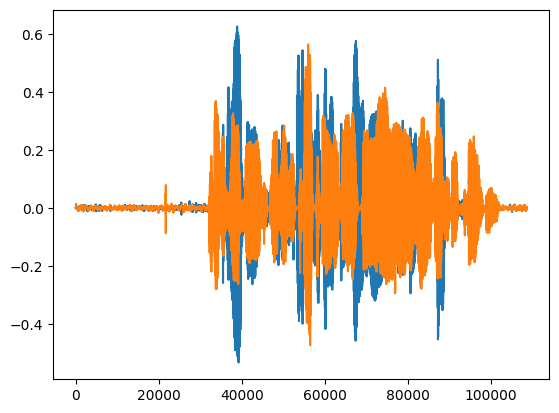

In [15]:
plt.plot(p225_wave)
plt.plot(p226_wave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Get Our Features and Labels

In [16]:
audio_files = []
speaker_labels = []

data_dir = '/data'  # Replace with the path to your reorganized data

for speaker_dir in sorted(os.listdir(data_dir)):
    speaker_path = os.path.join(data_dir, speaker_dir)
    if os.path.isdir(speaker_path):
        speaker_id = speaker_dir  # Use speaker directory name as label
        for file_name in sorted(os.listdir(speaker_path)):
            file_path = os.path.join(speaker_path, file_name)
            audio_files.append(file_path)
            speaker_labels.append(speaker_id)

print(f'audio_files: {audio_files}')
print(f'speaker_labels: {speaker_labels}')

audio_files: ['/data/Speaker225/p225_014.wav', '/data/Speaker225/p225_016.wav', '/data/Speaker225/p225_025.wav', '/data/Speaker225/p225_026.wav', '/data/Speaker225/p225_027.wav', '/data/Speaker225/p225_030.wav', '/data/Speaker225/p225_033.wav', '/data/Speaker225/p225_046.wav', '/data/Speaker225/p225_051.wav', '/data/Speaker225/p225_057.wav', '/data/Speaker225/p225_066.wav', '/data/Speaker225/p225_071.wav', '/data/Speaker225/p225_072.wav', '/data/Speaker225/p225_109.wav', '/data/Speaker225/p225_121.wav', '/data/Speaker225/p225_126.wav', '/data/Speaker225/p225_128.wav', '/data/Speaker225/p225_141.wav', '/data/Speaker225/p225_149.wav', '/data/Speaker225/p225_176.wav', '/data/Speaker225/p225_179.wav', '/data/Speaker226/p226_014.wav', '/data/Speaker226/p226_016.wav', '/data/Speaker226/p226_025.wav', '/data/Speaker226/p226_026.wav', '/data/Speaker226/p226_027.wav', '/data/Speaker226/p226_030.wav', '/data/Speaker226/p226_033.wav', '/data/Speaker226/p226_046.wav', '/data/Speaker226/p226_051.wa

## 3.2 Creating the TF Dataset

In [17]:
filenames_ds = tf.data.Dataset.from_tensor_slices(audio_files)
labels_ds = tf.data.Dataset.from_tensor_slices(speaker_labels)

print(f'filenames_ds: {filenames_ds}')
print(f'labels_ds: {labels_ds}')

filenames_ds: <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
labels_ds: <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


## 3.3 Load Audio and Combine

In [18]:
def load_audio_label(file_path, label):
    audio = load_wav_16k_mono(file_path)  # Using your existing function
    return audio, label

# Create a zipped dataset of file paths and labels (file path, label)
zipped_ds = tf.data.Dataset.zip((filenames_ds, labels_ds))

# Map load_audio_label to the zipped dataset
audio_ds = zipped_ds.map(load_audio_label)  # Pass both file_path and label to load_audio_label

final_ds = audio_ds # audio_ds contains (audio, label) pairs

# 4. Determining Lengths

## 4.1 Calculate Wave Cycle Lengths For Each Speaker

In [19]:
speaker_lengths = {}  # Initialize an empty dictionary

# Assuming you have audio_ds with (audio, label) pairs
for audio, label in audio_ds:
    length = len(audio)  # Get length of the audio tensor
    speaker_id = label.numpy().decode('utf-8') # Extract speaker ID

    # Store in the dictionary: {speaker_id: [lengths]}
    if speaker_id not in speaker_lengths:
        speaker_lengths[speaker_id] = []
    speaker_lengths[speaker_id].append(length)

print(speaker_lengths)

{'Speaker225': [106522, 125634, 56665, 41004, 49915, 72405, 106539, 60842, 41665, 103771, 54651, 37550, 55369, 40992, 37632, 26825, 45819, 46056, 79231, 70354, 49889], 'Speaker226': [108600, 137984, 60814, 43018, 90166, 62864, 83296, 98320, 67668, 43759, 38312, 104503, 107188, 59471, 70362, 81931, 90863, 57382, 75146, 75143, 75111], 'Speaker227': [99738, 128351, 58108, 45128, 48528, 56010, 44382, 40344, 56696, 38986, 66238, 55329, 69650, 54003, 73803, 92205, 106523, 45111, 65551, 48541, 72427], 'Speaker228': [93588, 131089, 36191, 80608, 34825, 41682, 63570, 26670, 58069, 62867, 83309, 36882, 30078, 99689, 60823, 56058, 58102, 54663, 89461, 62154, 75860], 'Speaker229': [77226, 96983, 25982, 54000, 28757, 54012, 30764, 40311, 43700, 30059, 30122, 33521, 48554, 44415, 56052, 39623, 57361, 38286, 68342, 32111, 73116], 'Speaker230': [94267, 144071, 37622, 52610, 64762, 78520, 74416, 47795, 49915, 65587, 66229, 30043, 44393, 59455, 64929, 64225, 36921, 32820, 77182, 79274, 53280], 'Speaker2

## 4.2 Calculate the Mean, Min, and Max Again For Each Speaker

In [23]:
speaker_stats = {}  # Dictionary to store statistics

for speaker_id, lengths in speaker_lengths.items():
    # Convert lengths to a TensorFlow tensor
    lengths_tensor = tf.constant(lengths, dtype=tf.float32)

    # Calculate mean, min, and max
    mean = tf.reduce_mean(lengths_tensor).numpy()
    minimum = tf.reduce_min(lengths_tensor).numpy()
    maximum = tf.reduce_max(lengths_tensor).numpy()

    # Store in the speaker_stats dictionary
    speaker_stats[speaker_id] = {
        'mean': mean,
        'min': minimum,
        'max': maximum
    }

# Stats for Speaker225
print(speaker_stats['Speaker225'])

{'mean': 62349.047, 'min': 26825.0, 'max': 125634.0}


# 5. Build Preprocessing Function to Convert to Spectogram

## 5.1 Build Preprocessing Function

In [ ]:
def preprocess(file_path, label):
  """
  Preprocess the file path and label into spectrogram

  :param file_path: Path to the audio file
  :param label: Label for the audio file

  :return: Spectrogram and label
  """
  wav = load_wav_16k_mono(file_path)
  wav = wav[:48000] # grab first 48000 steps from signals
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)   # not all audio will meet 48000 so pad with zeros
  wav = tf.concat([zero_padding, wav],0) # append all the zeros in the start to give us our final file
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=3) # short time fourier (creates spectogram)
  spectrogram = tf.abs(spectrogram) # gets rid of negatives
  spectrogram = tf.expand_dims(spectrogram, axis=2) # encaps spectogram in array to produce our deep learning model
  return spectrogram, label

In [28]:
wav = load_wav_16k_mono(P225_WAV_FILE)
wav = wav[:48000] # grab first 48000 steps from signals
zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)   # not all audio will meet 48000 so pad with zeros
wav = tf.concat([zero_padding, wav],0) # append all the ze
wav

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([-2.1688676e-08,  2.5889070e-08, -6.1285981e-09, ...,
       -1.1756761e-03, -3.4636777e-04, -2.3345968e-03], dtype=float32)>

In [29]:
spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=3)

In [30]:
spectrogram

<tf.Tensor: shape=(15894, 257), dtype=complex64, numpy=
array([[ 4.35805619e-02+0.00000000e+00j,  1.58492565e-01-1.05281793e-01j,
        -1.74088985e-01-1.40050083e-01j, ...,
        -1.27404928e-06-7.30156898e-07j, -3.87430191e-07+2.30967999e-07j,
        -3.03611159e-07+0.00000000e+00j],
       [ 2.94098258e-02+0.00000000e+00j,  1.64134204e-01-9.25898254e-02j,
        -1.66407660e-01-1.48699164e-01j, ...,
         1.32620335e-06+4.84287739e-07j,  3.72529030e-07-2.45869160e-07j,
         2.57045031e-07+0.00000000e+00j],
       [ 1.51718175e-02+0.00000000e+00j,  1.69248611e-01-7.96987191e-02j,
        -1.58274800e-01-1.56891346e-01j, ...,
        -1.36345625e-06-2.23517418e-07j, -3.79979610e-07+2.38418579e-07j,
        -1.81607902e-07+0.00000000e+00j],
       ...,
       [-2.30326772e-01+0.00000000e+00j,  1.16286099e-01+1.78677231e-01j,
         8.40012878e-02-1.34964824e-01j, ...,
        -1.40406191e-05+6.35534525e-06j,  4.93228436e-06+9.49949026e-06j,
         7.00354576e-06+0.0000

## 5.2 Test Out the Function and Vizualize the Spectogram